In [2]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image
import scipy
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import Callback
from keras.losses import mean_squared_error
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/SRx4_Fiji_4channel.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
                                                    'charbonnierLoss': charbonnierLoss})

In [3]:
def loadrasterRGB(filepath,channels):
    img = gdal.Open(filepath)

    xsize = img.RasterXSize
    ysize = img.RasterYSize

    image = np.zeros((ysize,xsize,len(channels)))

    for band in range(len(channels)):
        imgband = img.GetRasterBand(channels[band])
        image[:,:,band] = imgband.ReadAsArray()
    return image

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval):
    fixed_img = img
    fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=np.uint8)
    return fixed_img

/home/asli/NeMO-Test/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


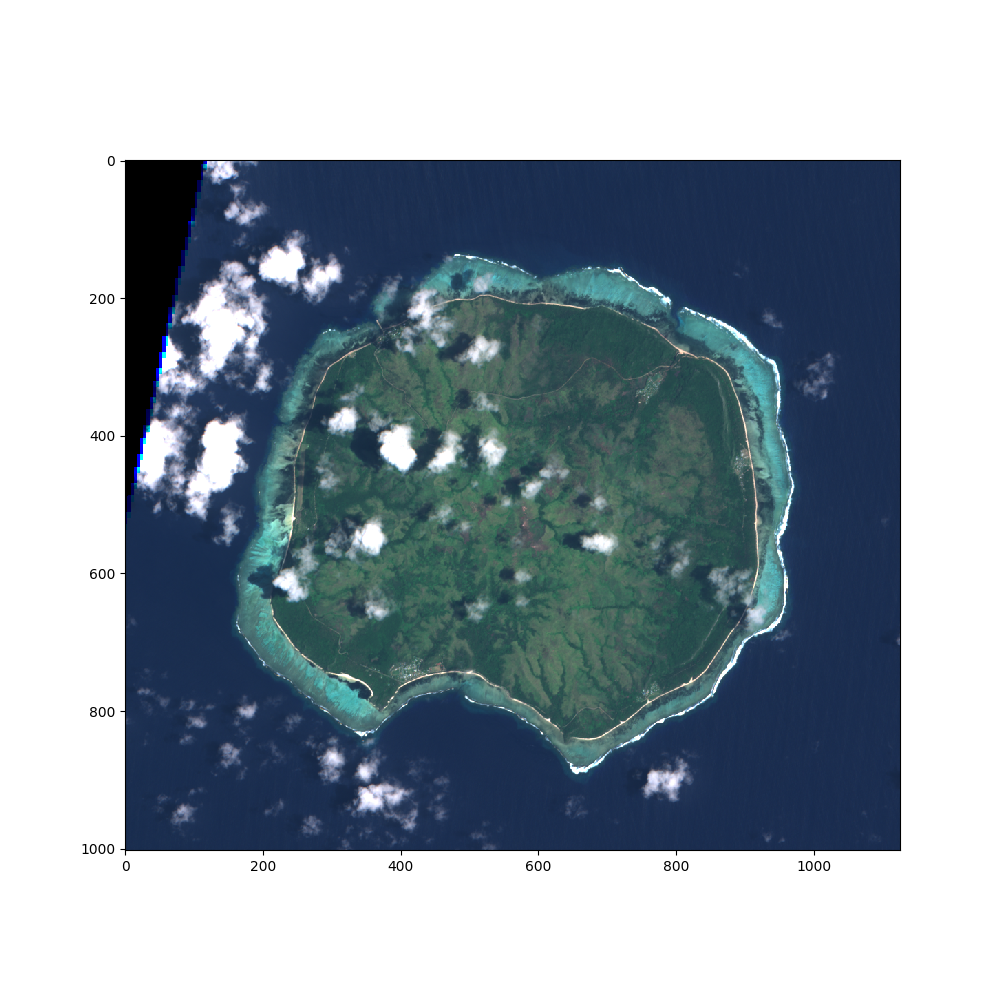

<IPython.core.display.Javascript object>


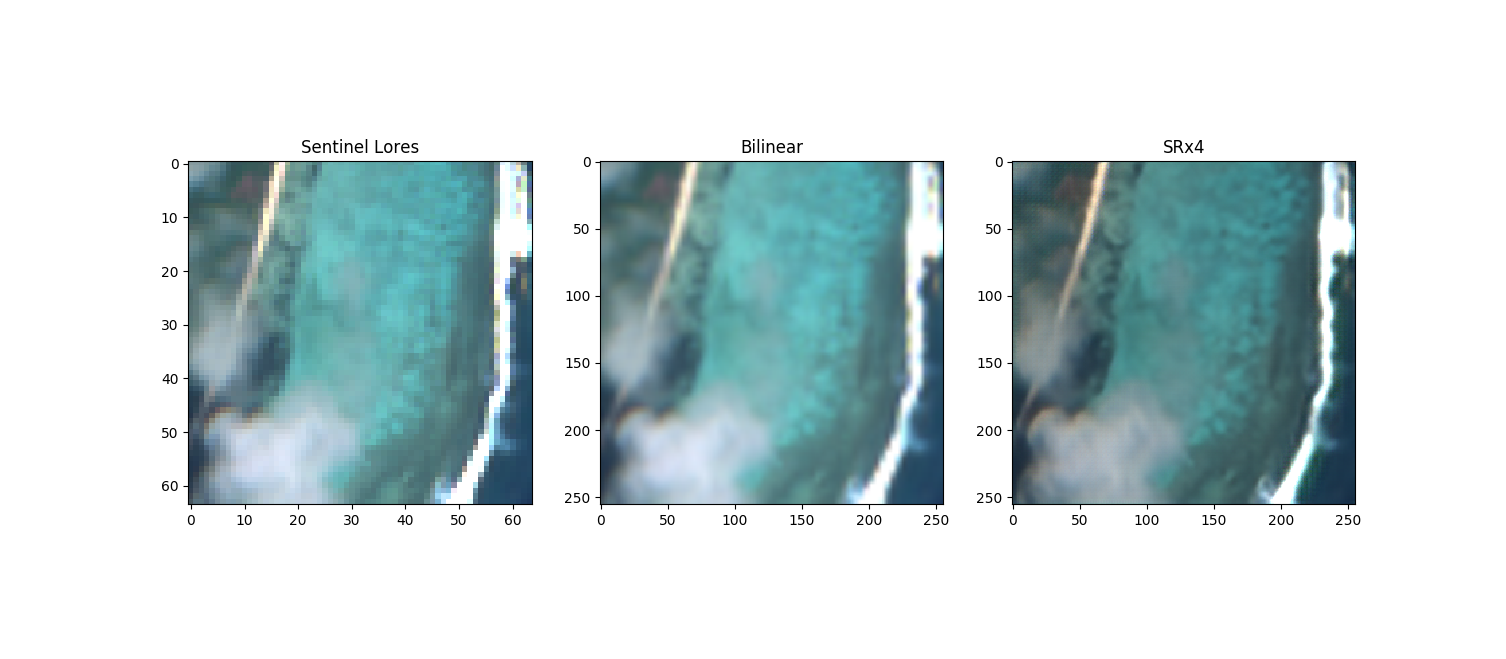

1483.5 889.6844706219134


/home/asli/NeMO-Test/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [66]:
# 4 channel code for Sentinel data
filepath_Sentinel = "/home/shared/NeMO-Net Data/Sentinel/Cicia/STL_4band_2016-01-17.tif"
Fiji_Sentinel = coralutils.CoralData(filepath_Sentinel, load_type="raster")

# Just some visualizations of RGB
patch_R = 255/3000*Fiji_Sentinel.image[:,:,0]
patch_G = 255/3000*Fiji_Sentinel.image[:,:,1]
patch_B = 255/3000*Fiji_Sentinel.image[:,:,2]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)

fig = plt.figure(1,figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.imshow(Fiji_RGB)
plt.show()

ymin = 604
xmin = 900
l = 64
samplepatch_RGB = Fiji_Sentinel.image[ymin:ymin+l,xmin:xmin+l,:3]
samplepatch_RGB = np.asarray(np.clip(255/3000*samplepatch_RGB,0,255), dtype=np.uint8)

fig = plt.figure(2)
ax = plt.subplot(1,3,1)
ax.imshow(samplepatch_RGB)
ax.set_title('Sentinel Lores')
plt.show()

# Turn patch into standardized BGR + NIR
pixel_mean = 1500
pixel_std = 1500
samplepatch = np.dstack((Fiji_Sentinel.image[ymin:ymin+l,xmin:xmin+l,2::-1],Fiji_Sentinel.image[ymin:ymin+l,xmin:xmin+l,-1])) #BGR+NIR
print(np.median(samplepatch), np.std(samplepatch))
samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
samplepatch = (samplepatch-pixel_mean)/pixel_std

imgresize = scipy.misc.imresize(samplepatch_RGB,400,'bilinear')
# imgresize = fixRGBimg(imgresize,100,100,0,255)
ax = plt.subplot(1,3,2)
ax.set_title('Bilinear')
ax.imshow(imgresize)

imgbatch = np.expand_dims(samplepatch, axis=0)
imgpredict = model.predict(imgbatch, batch_size = 1)[0]
imgpredict = fixRGBimg(imgpredict,100,100,0,255)
imgpredict_fix = np.zeros((imgpredict.shape[0],imgpredict.shape[1],3))
imgpredict_fix[:,:,0] = imgpredict[:,:,2]
imgpredict_fix[:,:,1] = imgpredict[:,:,1]
imgpredict_fix[:,:,2] = imgpredict[:,:,0]
imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)

ax = plt.subplot(1,3,3)
ax.imshow(imgpredict_fix)
ax.set_title('SRx4')
plt.show()



Class:  Urban
53.72857856750488 30.69352997751773
channels_last


/home/asli/NeMO-Test/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


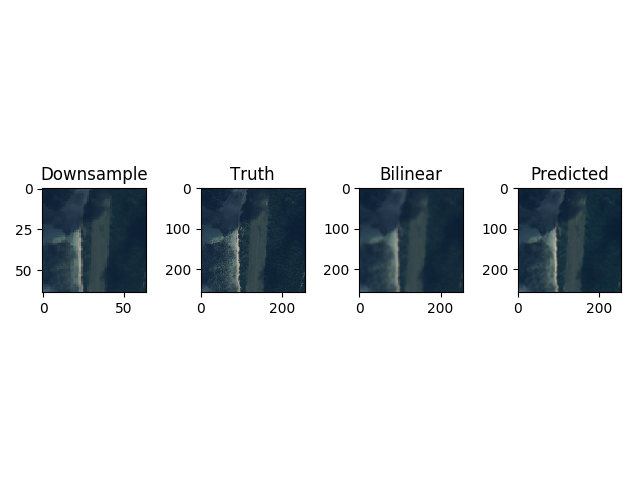

MSE and PSNR for NN predicted:  57.87052917480469 30.50622907247289
MSE and PSRN for Bilinear upsampling:  65.2286376953125 29.986420525215173
Class:  Mud flats
61.96988487243652 46.18686972310609
channels_last


<IPython.core.display.Javascript object>


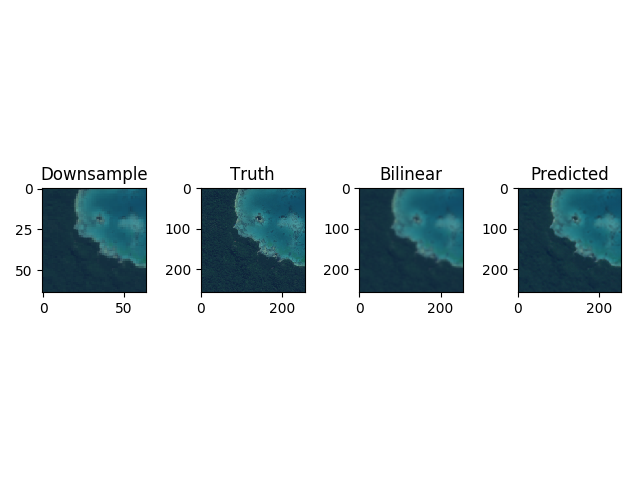

MSE and PSNR for NN predicted:  55.625091552734375 30.678096220777604
MSE and PSRN for Bilinear upsampling:  53.975982666015625 30.808798031910843
Class:  Dense macroalgae on sediment
135.5426483154297 76.93753258141868
channels_last


<IPython.core.display.Javascript object>


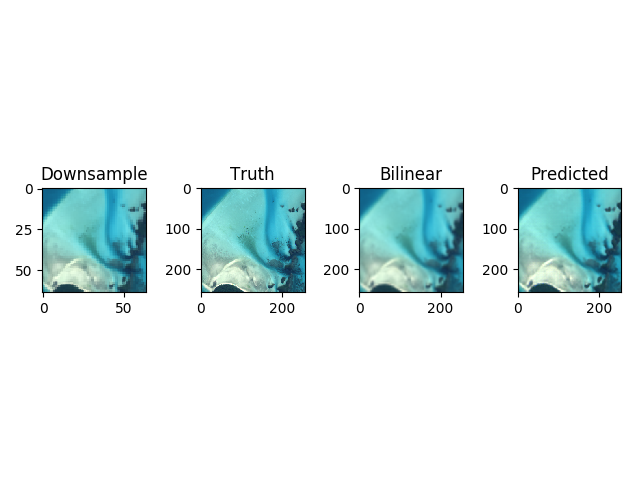

MSE and PSNR for NN predicted:  113.87197875976562 27.56663493392836
MSE and PSRN for Bilinear upsampling:  93.74295043945312 28.411417426053227
Class:  Lagoonal pinnacle reefs massive coral dominated
64.7015609741211 56.22220560379505
channels_last


<IPython.core.display.Javascript object>


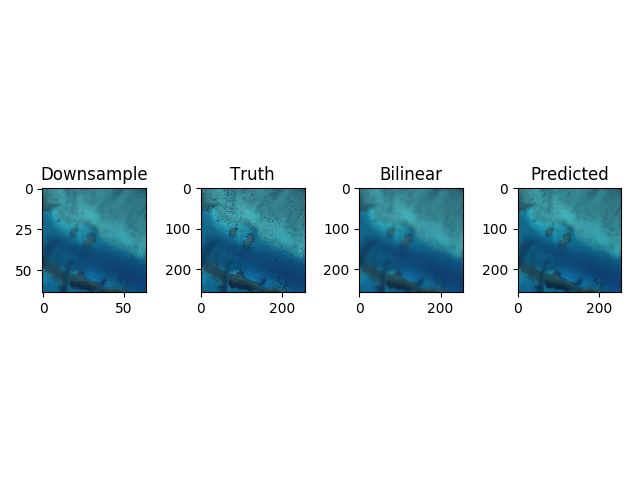

MSE and PSNR for NN predicted:  75.19293212890625 29.369033405112837
MSE and PSRN for Bilinear upsampling:  73.1717529296875 29.487369015899972
Class:  Deep ocean water
33.33015823364258 23.4409094824228
channels_last


<IPython.core.display.Javascript object>


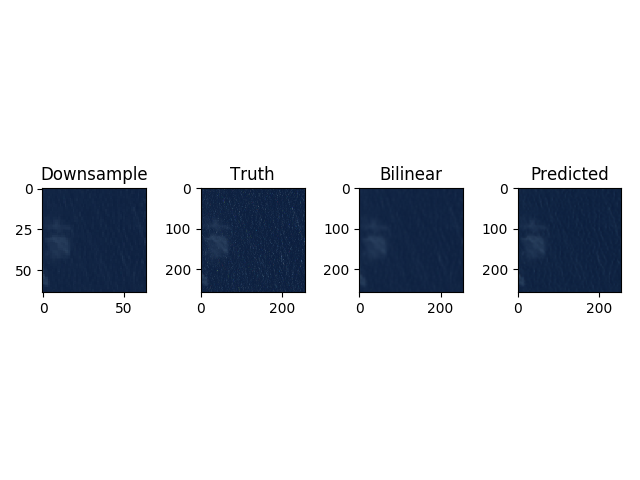

MSE and PSNR for NN predicted:  49.552734375 31.18012736532814
MSE and PSRN for Bilinear upsampling:  49.10725402832031 31.21934710867645
Class:  Fore reef sand flats
47.93214797973633 36.6294284865247
channels_last


<IPython.core.display.Javascript object>


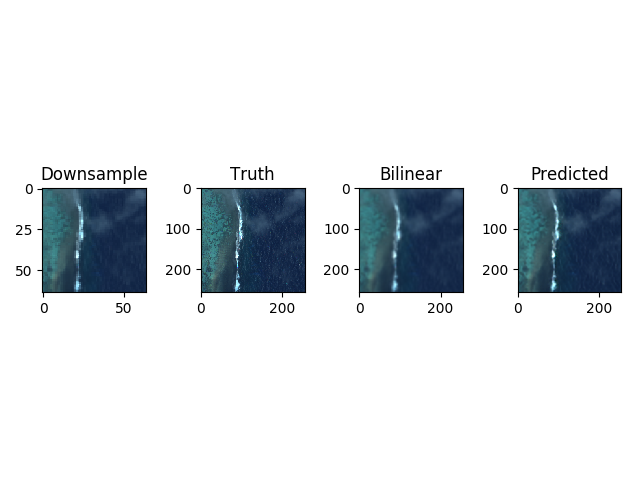

MSE and PSNR for NN predicted:  97.39959716796875 28.245232001709176
MSE and PSRN for Bilinear upsampling:  90.22819519042969 28.577380904854714
Class:  Deep fore reef slope
34.87766647338867 29.892548061970555
channels_last


<IPython.core.display.Javascript object>


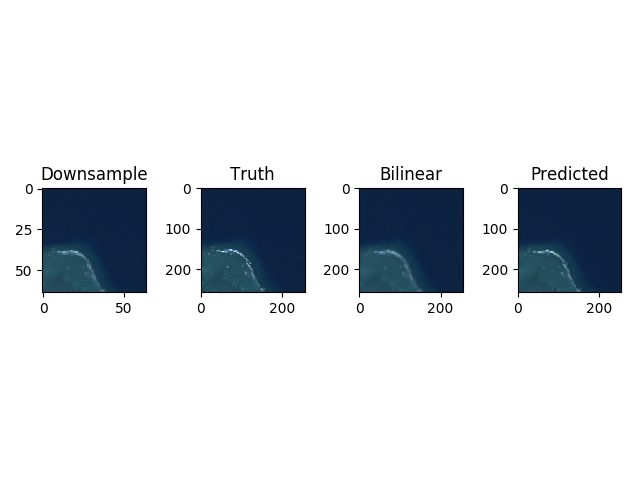

MSE and PSNR for NN predicted:  21.9210205078125 34.72219592506528
MSE and PSRN for Bilinear upsampling:  20.934967041015625 34.92208079372035
Class:  Dense seagrass meadows
61.181880950927734 35.100321345822906
channels_last


<IPython.core.display.Javascript object>


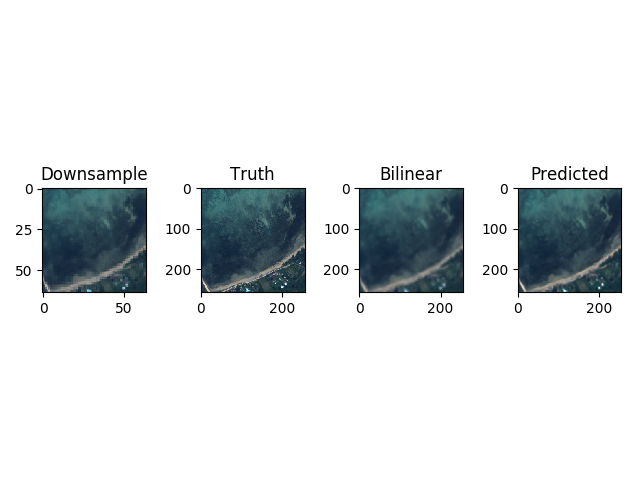

MSE and PSNR for NN predicted:  93.55587768554688 28.420092834497098
MSE and PSRN for Bilinear upsampling:  115.92732238769531 27.4889455593295
Class:  Back reef sediment dominated
79.38343811035156 41.512216408457554
channels_last


<IPython.core.display.Javascript object>


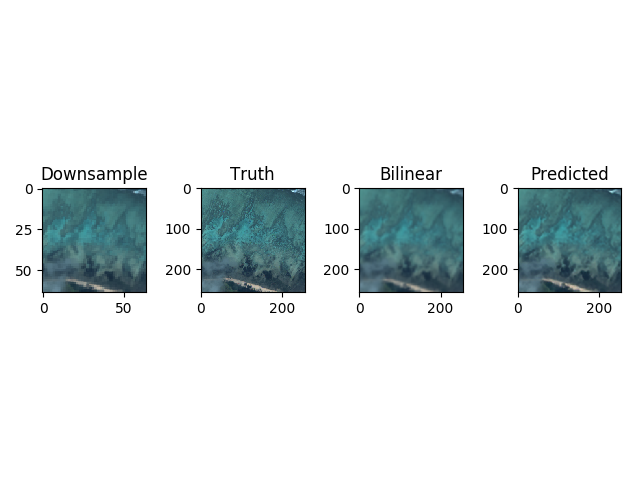

MSE and PSNR for NN predicted:  127.97959899902344 27.059396158160865
MSE and PSRN for Bilinear upsampling:  149.544921875 26.38308690669481
Class:  NoData
51.53301811218262 17.029222710778168
channels_last


<IPython.core.display.Javascript object>


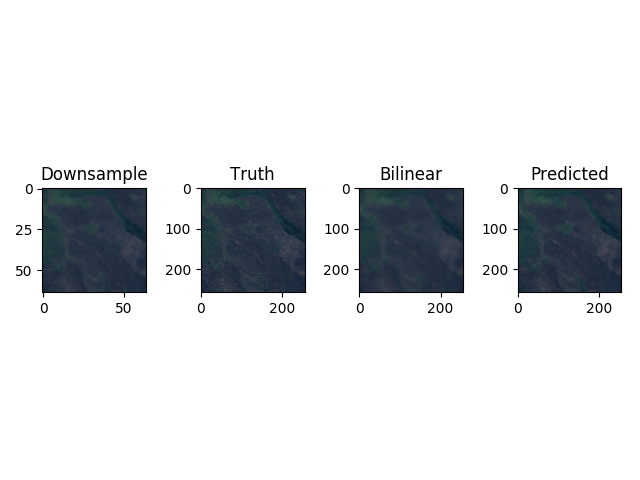

MSE and PSNR for NN predicted:  43.62068176269531 31.733879118337867
MSE and PSRN for Bilinear upsampling:  40.87089538574219 32.016662086755865
Class:  Inland waters
52.49093055725098 43.08100898847216
channels_last


<IPython.core.display.Javascript object>


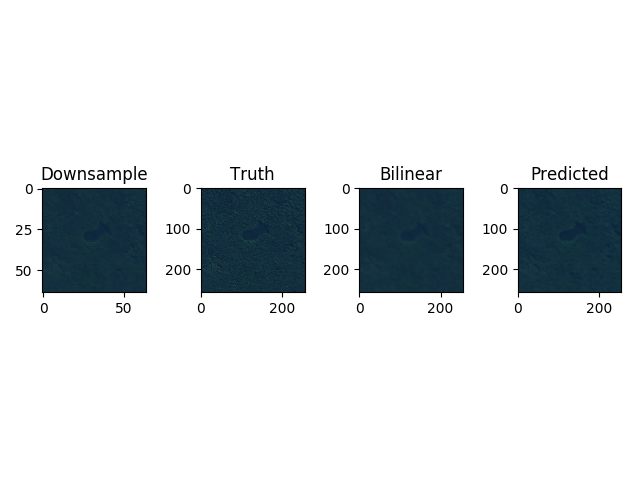

MSE and PSNR for NN predicted:  40.763519287109375 32.02808689434576
MSE and PSRN for Bilinear upsampling:  35.82002258300781 32.58954505550526
Class:  Lagoonal floor bommie field
45.29878807067871 48.18885208932356
channels_last


<IPython.core.display.Javascript object>


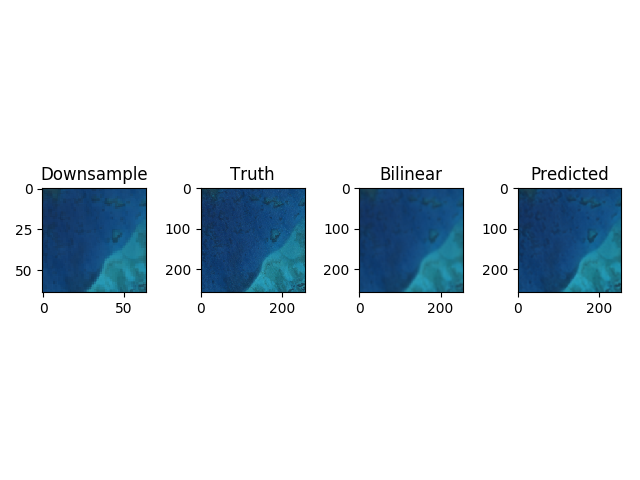

MSE and PSNR for NN predicted:  44.02317810058594 31.693989691356855
MSE and PSRN for Bilinear upsampling:  50.97120666503906 31.0575544590261
Class:  Back reef rubble dominated
52.432058334350586 48.05623901095675
channels_last


<IPython.core.display.Javascript object>


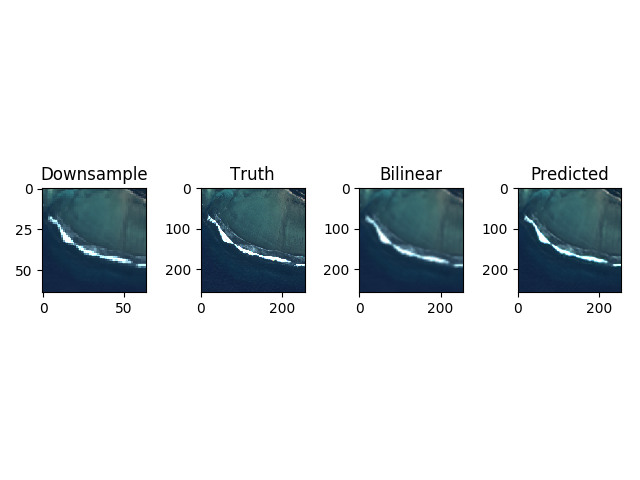

MSE and PSNR for NN predicted:  52.299713134765625 30.945810541101967
MSE and PSRN for Bilinear upsampling:  66.38166809082031 29.910321993645283
Class:  Lagoonal patch reefs
56.4489803314209 50.25157887566876
channels_last


<IPython.core.display.Javascript object>


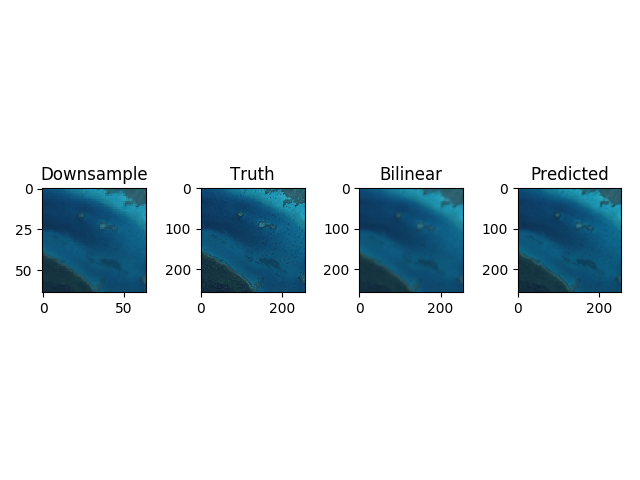

MSE and PSNR for NN predicted:  51.97404479980469 30.972938444321947
MSE and PSRN for Bilinear upsampling:  49.59135437011719 31.17674391567801
Class:  Lagoonal floor coral bommies
58.49307060241699 49.0268865735347
channels_last


<IPython.core.display.Javascript object>


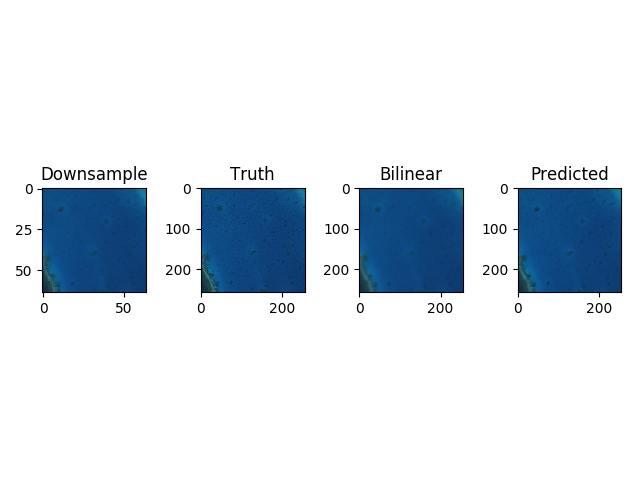

MSE and PSNR for NN predicted:  41.14768981933594 31.98734903503789
MSE and PSRN for Bilinear upsampling:  38.88612365722656 32.2328570797969
Class:  Lagoonal fringing reefs
56.17652702331543 43.20939607252712
channels_last


<IPython.core.display.Javascript object>


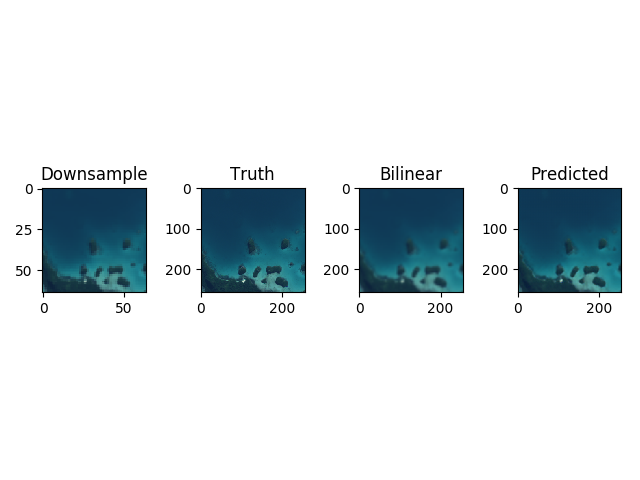

MSE and PSNR for NN predicted:  30.883544921875 33.23353216495378
MSE and PSRN for Bilinear upsampling:  33.39862060546875 32.89351830457665
Class:  Terrestrial vegetation
51.90445327758789 21.499126321191167
channels_last


<IPython.core.display.Javascript object>


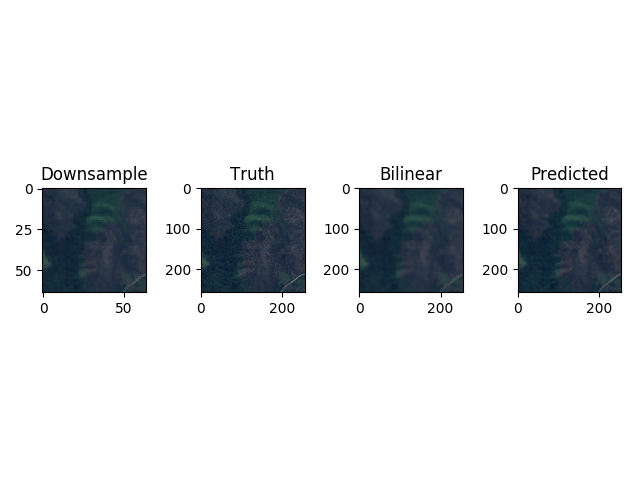

MSE and PSNR for NN predicted:  48.237762451171875 31.296932063802295
MSE and PSRN for Bilinear upsampling:  52.00006103515625 30.97076507478957
Class:  Lagoonal floor macroalgae on sediment
68.37315368652344 55.96177023858312
channels_last


<IPython.core.display.Javascript object>


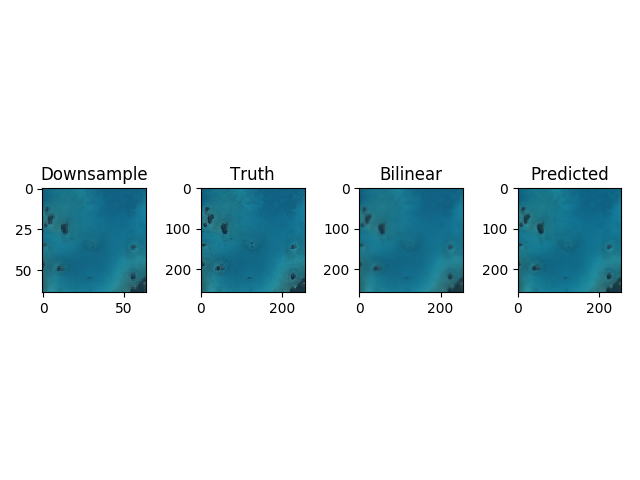

MSE and PSNR for NN predicted:  33.222686767578125 32.91645609298299
MSE and PSRN for Bilinear upsampling:  21.942581176757812 34.71792647160336
Class:  Shallow fore reef terrace
41.00475311279297 36.68116869701269
channels_last


/home/asli/NeMO-Test/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


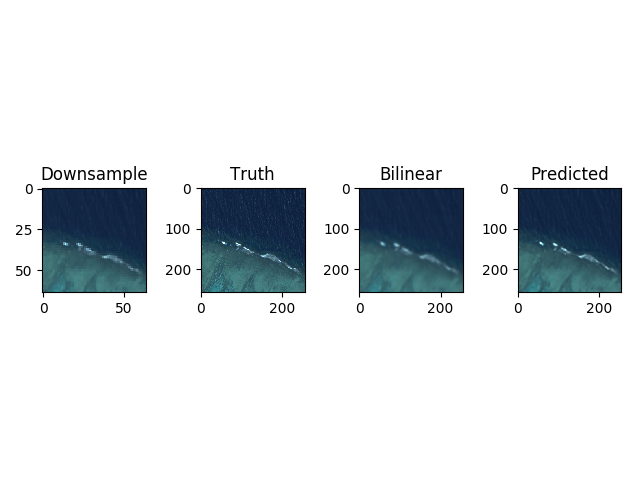

MSE and PSNR for NN predicted:  73.44361877441406 29.47126293232462
MSE and PSRN for Bilinear upsampling:  83.00852966308594 28.93957639633048
Class:  Lagoonal floor barren
32.527466773986816 34.329155559035186
channels_last


<IPython.core.display.Javascript object>


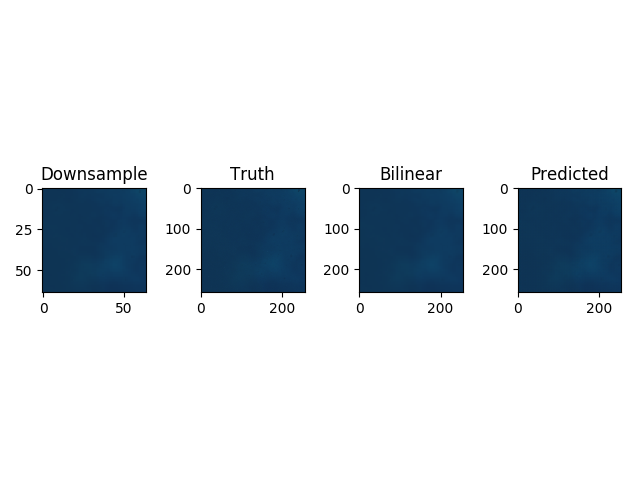

MSE and PSNR for NN predicted:  2.88177490234375 43.53420306141467
MSE and PSRN for Bilinear upsampling:  1.41546630859375 46.621808242674305
Class:  Deep lagoonal water
43.22014045715332 30.222352421342965
channels_last


<IPython.core.display.Javascript object>


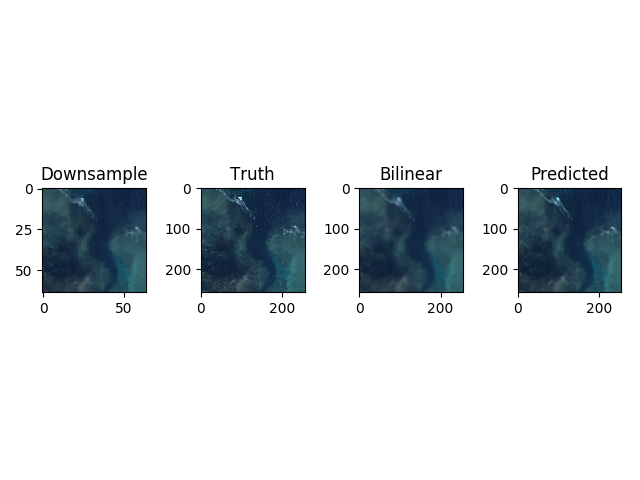

MSE and PSNR for NN predicted:  70.91462707519531 29.623445374921836
MSE and PSRN for Bilinear upsampling:  83.67214965820312 28.90499434087255
Class:  Coralline algal ridge
46.812612533569336 48.20900505473207
channels_last


<IPython.core.display.Javascript object>


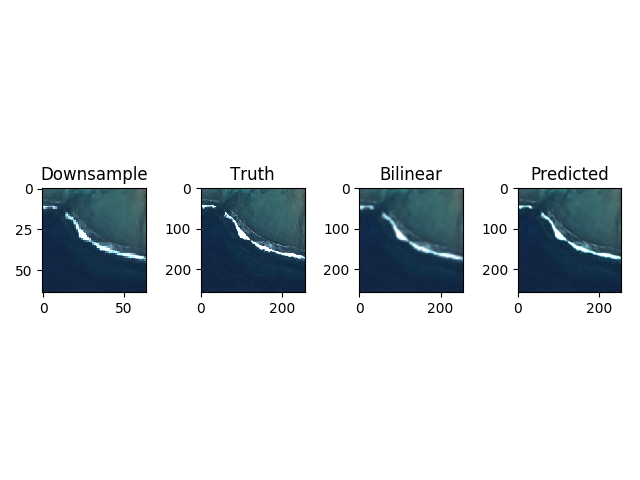

MSE and PSNR for NN predicted:  53.277374267578125 30.865375480315237
MSE and PSRN for Bilinear upsampling:  60.67889404296875 30.300427043005648
Class:  Mangroves
55.34089469909668 40.102517210394154
channels_last


<IPython.core.display.Javascript object>


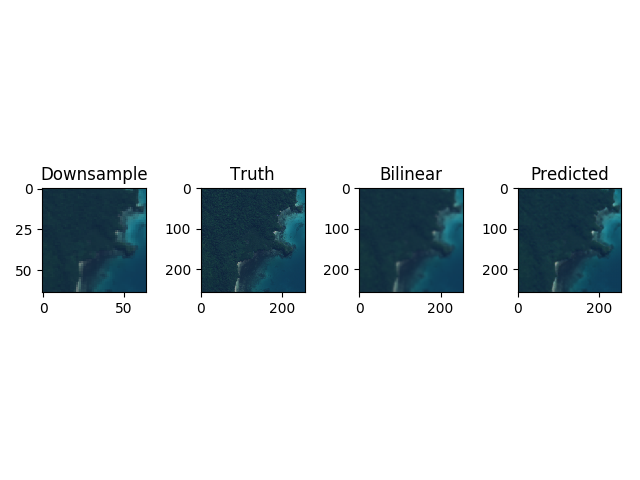

MSE and PSNR for NN predicted:  43.88427734375 31.707714097807646
MSE and PSRN for Bilinear upsampling:  44.81452941894531 31.616615204531257
Class:  Back reef pavement
50.8487434387207 33.690513599496434
channels_last


<IPython.core.display.Javascript object>


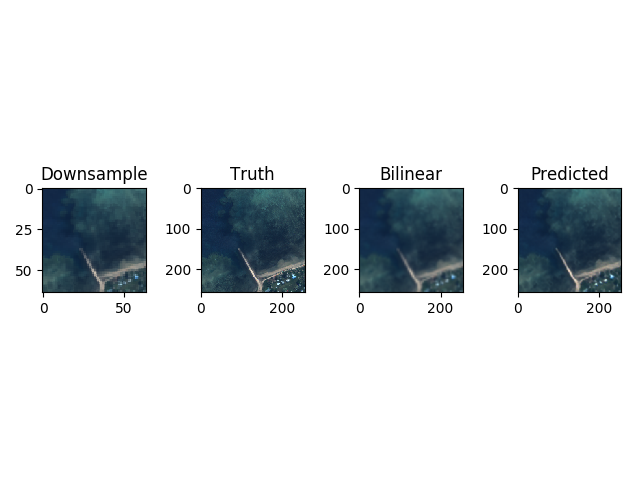

MSE and PSNR for NN predicted:  67.24136352539062 29.85443849355251
MSE and PSRN for Bilinear upsampling:  79.90440368652344 29.10509646083888
Class:  Back reef coral bommies
70.93971633911133 46.82884769920279
channels_last


<IPython.core.display.Javascript object>


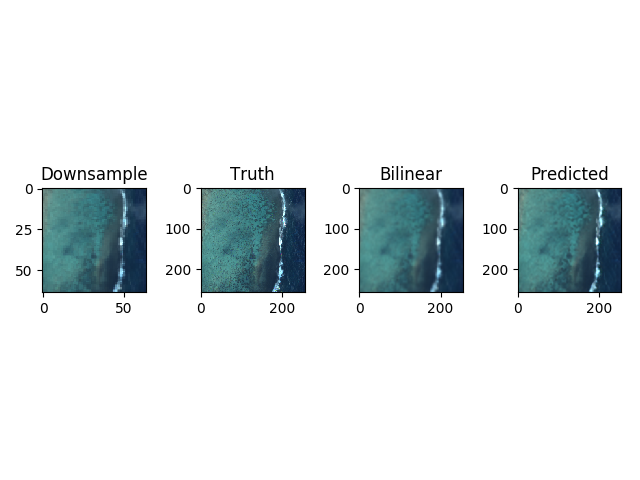

MSE and PSNR for NN predicted:  114.35018920898438 27.548434733212964
MSE and PSRN for Bilinear upsampling:  119.57742309570312 27.354311707683514
Class:  Beach sand
59.959537506103516 47.943659749048166
channels_last


<IPython.core.display.Javascript object>


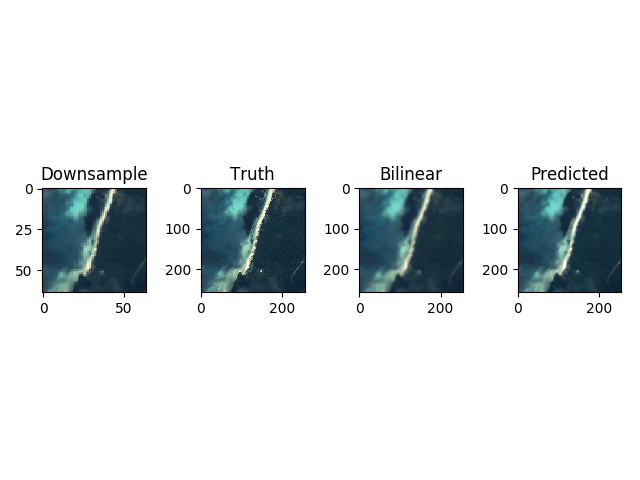

MSE and PSNR for NN predicted:  87.5157470703125 28.70994156412074
MSE and PSRN for Bilinear upsampling:  98.49824523925781 28.196518673215238
Class:  Shallow fore reef slope
38.08486557006836 40.46283908632327
channels_last


<IPython.core.display.Javascript object>


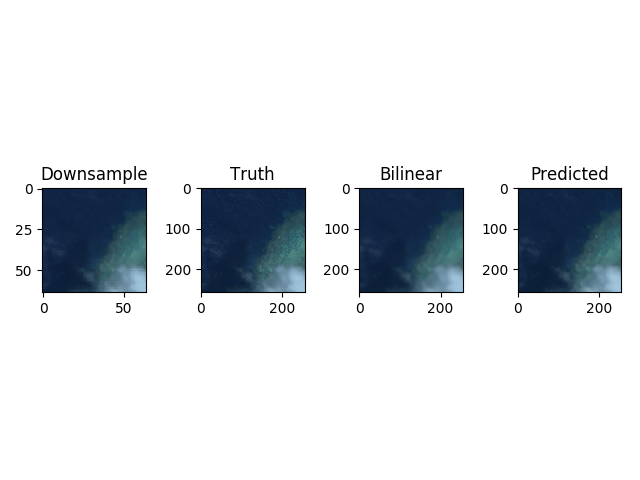

MSE and PSNR for NN predicted:  28.202102661132812 33.627988716944806
MSE and PSRN for Bilinear upsampling:  28.383773803710938 33.60010223686952
Class:  Back reef coral framework
62.7440185546875 42.50186298545716
channels_last


<IPython.core.display.Javascript object>


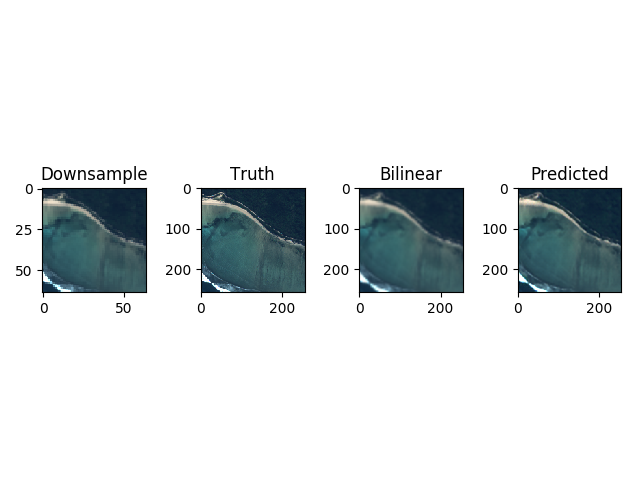

MSE and PSNR for NN predicted:  63.4627685546875 30.105613466522612
MSE and PSRN for Bilinear upsampling:  78.05061340332031 29.20704040315978
Class:  Lagoonal sediment apron sediment dominated
106.85747146606445 80.34642537017137
channels_last


<IPython.core.display.Javascript object>


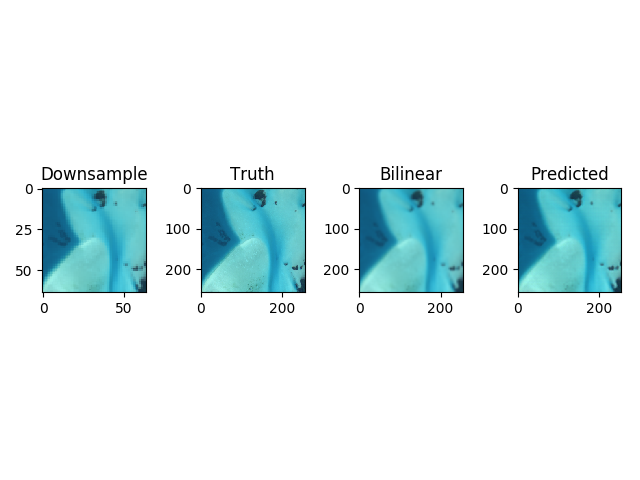

MSE and PSNR for NN predicted:  79.77522277832031 29.11212335200606
MSE and PSRN for Bilinear upsampling:  60.743072509765625 30.295836052203274
Class:  Clouds
58.52538871765137 24.440732739576056
channels_last


<IPython.core.display.Javascript object>


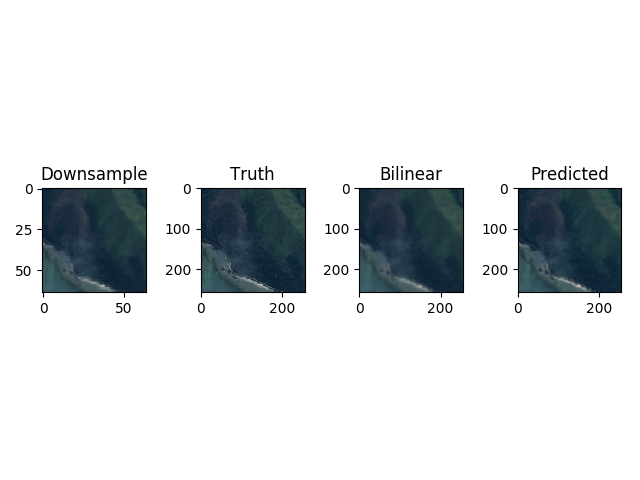

MSE and PSNR for NN predicted:  53.409515380859375 30.854617235161378
MSE and PSRN for Bilinear upsampling:  58.308349609375 30.47349611775541


In [41]:
# This code is for Fiji 8band converted to RGB
# imgpath = '../Images/Fiji_SR_ValidPatches_64/Lagoonal fringing reefs/Lagoonal fringing reefs_00000000.tif'
# truthpath = '../Images/Fiji_SR_ValidPatches_256/Lagoonal fringing reefs/Lagoonal fringing reefs_00000000.tif'
searchdir = "../Images/Fiji_SR_ValidPatches_64/"
hiresdir = "../Images/Fiji_SR_ValidPatches_256/"

pixel_mean = 100
pixel_std = 100
lores_size = 64
hires_size = 256
RGBchannels = [5,3,2]

figcount = 3

dir_list = [d for d in os.listdir(searchdir) if os.path.isdir(os.path.join(searchdir,d))]

for d in dir_list:
    print("Class: ", d)
    imgpath = searchdir + d + "/" + d + "_00000000.tif"
    truthpath = hiresdir + d + "/" + d + "_00000000.tif"

    origimg = loadrasterRGB(imgpath, RGBchannels)
    origimg = fixRGBimg(origimg,0,1,0,255)
    fullimg = loadrasterRGB(imgpath, [2,3,5,7])
    fullimg = fixRGBimg(fullimg,0,1,0,255)
    trueimg = loadrasterRGB(truthpath, RGBchannels)
    trueimg = fixRGBimg(trueimg,0,1,0,255)
    imgtruth = loadrasterRGB(truthpath, [2,3,5,7])
    imgtruth = fixRGBimg(imgtruth,0,1,0,255)

    imgresize = scipy.misc.imresize(origimg,400,'bilinear')
    # fullimgresize = scipy.misc.imresize(fullimg,400,'bilinear') # can't resize 8 channel array

    testimg = loadrasterRGB(imgpath, [2,3,5,7])
    testimg = img_to_array(testimg, data_format=K.image_data_format())
    testimg = (testimg-pixel_mean)/pixel_std
    imgbatch = np.expand_dims(testimg, axis=0)
    imgpredict = model.predict(imgbatch, batch_size = 1)[0]
    imgpredict = fixRGBimg(imgpredict,pixel_mean,pixel_std,0,255)
    imgpredict_fix = np.zeros((imgpredict.shape[0],imgpredict.shape[1],3))
    imgpredict_fix[:,:,0] = imgpredict[:,:,2]
    imgpredict_fix[:,:,1] = imgpredict[:,:,1]
    imgpredict_fix[:,:,2] = imgpredict[:,:,0]
    imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)

    fig = plt.figure(figcount)
    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow(origimg)
    ax1.set_title("Downsample")

    ax2 = fig.add_subplot(1,4,2)
    ax2.imshow(trueimg)
    ax2.set_title("Truth")

    ax3 = fig.add_subplot(1,4,3)
    ax3.imshow(imgresize)
    ax3.set_title("Bilinear")

    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(imgpredict_fix)
    ax4.set_title("Predicted")
    fig.tight_layout()
    plt.show()

    figcount += 1
    # Only do this for RGB
    MSE1 = np.sum(np.square(imgpredict_fix - trueimg))/(hires_size*hires_size)
    MSE2 = np.sum(np.square(trueimg - imgresize))/(hires_size*hires_size)
    PSNR1 = 10*np.log10(255*255/MSE1)
    PSNR2 = 10*np.log10(255*255/MSE2)

    print("MSE and PSNR for NN predicted: ", MSE1, PSNR1)
    print("MSE and PSRN for Bilinear upsampling: ", MSE2, PSNR2)
    

(1, 16, 16, 3)
(64, 64, 3)
[0.05882353 0.11372549 0.05882353]
[-0.03838708  0.07133056 -0.0624404 ]


c:\users\rechant\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


<IPython.core.display.Javascript object>


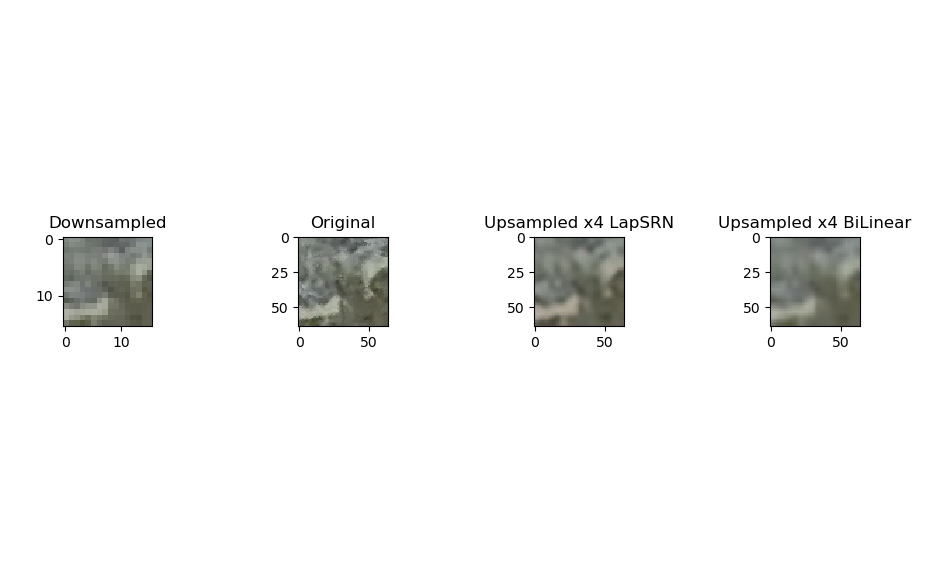

519.19287109375 20.97751640222558
771.383056640625 19.258102654723107


In [28]:
# This code was for Samoa RGB data

imgpath = '../Images/Training_Patchesx4/Branching/Branching_00000026.png'
truthpath = '../Images/TrainingRefx4_Patches/Branching/Branching_00000026.png'

pixel_mean = 127.5
pixel_std = 127.5
# RGBchannels = [4,2,1]

img = load_img(imgpath, grayscale=0, target_size=(16,16))
imgresize = scipy.misc.imresize(img,400,'bilinear')
img = img_to_array(img, data_format=K.image_data_format())
img = (img-pixel_mean)/pixel_std
imgbatch = np.expand_dims(img, axis=0)
print(imgbatch.shape)
imgpredict = model.predict(imgbatch, batch_size = 1)[0]


print(imgpredict.shape)
imgtruth = load_img(truthpath, grayscale=0, target_size=(64,64))
imgtruth = img_to_array(imgtruth, data_format=K.image_data_format())
imgtruth = (imgtruth-127.5)/127.5
print(imgtruth[0,0,:])
print(imgpredict[0,0,:])

# a = charbonnierLoss(imgtruth,imgpredict)
# init_op = tf.initialize_all_variables()
# with tf.Session() as sess:
#     sess.run(init_op)
#     print(sess.run(a))


fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(np.asarray(img*127.5+127.5,dtype=np.uint8))
ax1.set_title('Downsampled')

ax3 = fig.add_subplot(1,4,2)
ax3.imshow(np.asarray(imgtruth*127.5+127.5,dtype=np.uint8))
ax3.set_title('Original')

ax2 = fig.add_subplot(1,4,3)
ax2.imshow(np.asarray(imgpredict*127.5+127.5,dtype=np.uint8))
ax2.set_title('Upsampled x4 LapSRN')

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.asarray(imgresize,dtype=np.uint8))
ax4.set_title('Upsampled x4 BiLinear')

fig.tight_layout()
plt.show()

MSE1 = np.sum(np.square((imgpredict*127.5+127.5) - (imgtruth*127.5+127.5)))/(64*64)
MSE2 = np.sum(np.square((imgtruth*127.5+127.5) - (imgresize)))/(64*64)
PSNR1 = 10*np.log10(255*255/MSE1)
PSNR2 = 10*np.log10(255*255/MSE2)
    
print(MSE1, PSNR1)
print(MSE2, PSNR2)

